# Covid Data Experiment

This project is dedicated to the application of machine learning algorithms and tools to analysis of anthropological and sociological datasets. We would experiment with both supervised and unsupervised learning algorithms, such as clustering, decision trees, association rules, and artificial neural networks and many others. The goal is to extract meaningful patterns from such datasets as World Value Survey.

Before we apply any algorithms to the WVS data, we need to make sure that the data has high quality. We need to detect and correct corrupt, invalid, or inaccurate records from the data set and changing the range of data value for easiler processing later.

## 1. Data cleaning
For this experiment, we use two datasets below: 

The Coronavirus (COVID-19) Cases and Deaths dataset is provided by World Health Organization and updated daily. It contains the historical record of covid cases and deaths for each country. The visualization, downloadable dataset and meta data information can be found [here](https://data.humdata.org/dataset/coronavirus-covid-19-cases-and-deaths)

The cultural dataset collected from World Value Survey for people of different countries, and processed by the previous experiment can be found [here](https://drive.google.com/file/d/1fP7nbP6QOKhaqgK8pMM8SG8earKWgEO1/view?usp=sharing). For demonstration purposes, we only use the representative countries selected [here](https://docs.google.com/spreadsheets/d/1yOFofd2kWRAhTduM3jKZifw91Dm6g1T5HO2i4xR-agA/edit?usp=sharing)

### 1.1 Request and load covid dataset
Since the covid dataset is updated daily, we request the covid dataset every time we use it to get the most recent data.

In [1]:
import requests

csv_url = "https://covid19.who.int/WHO-COVID-19-global-data.csv"

req = requests.get(csv_url)
url_content = req.content

output_file = "../data_set/covid_data.csv"
csv_file = open(output_file, 'wb')

csv_file.write(url_content)
csv_file.close()

In [2]:
import pandas as pd
import numpy as np

culture_file = "../data_set/cultural_data/clean_data/data_2.csv"

covid_data = pd.read_csv(output_file)
cultural_data = pd.read_csv(culture_file)

covid_data.tail()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
85914,2020-12-25,ZW,Zimbabwe,AFRO,242,12786,13,339
85915,2020-12-26,ZW,Zimbabwe,AFRO,94,12880,2,341
85916,2020-12-27,ZW,Zimbabwe,AFRO,83,12963,0,341
85917,2020-12-28,ZW,Zimbabwe,AFRO,0,12963,0,341
85918,2020-12-29,ZW,Zimbabwe,AFRO,185,13148,13,354


### 1.2 Preprocess covid dataset

In [3]:
# Convert datatime to day in int
covid_data['Date_reported'] = pd.to_datetime(covid_data['Date_reported'])

start_date = pd.Timestamp("2020-01-03")
covid_data['Date_reported'] = covid_data['Date_reported'] - start_date
covid_data['Date_reported'] = covid_data['Date_reported'].dt.days

# Convert other attribtues to int
covid_data[['New_cases','Cumulative_cases', 'New_deaths', 'Cumulative_deaths']] = covid_data[['New_cases','Cumulative_cases', 'New_deaths', 'Cumulative_deaths']].astype(int)

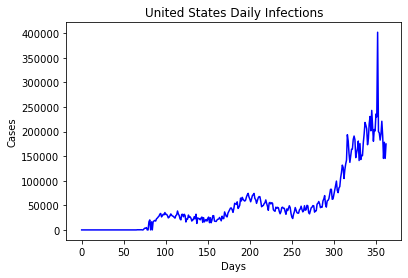

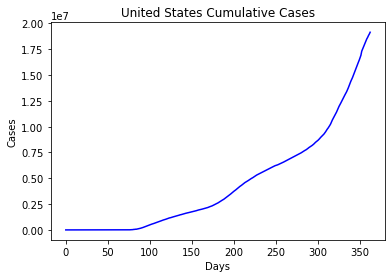

In [4]:
import matplotlib.pyplot as plt

us_new_cases = covid_data[covid_data["Country"] == "United States of America"]

plt.plot(us_new_cases["Date_reported"],us_new_cases["New_cases"], color='b',label="new cases")
plt.title("United States Daily Infections")
plt.xlabel("Days")
plt.ylabel("Cases")
plt.show()

plt.plot(us_new_cases["Date_reported"],us_new_cases["Cumulative_cases"], color='b',label="cumulative cases")
plt.title("United States Cumulative Cases")
plt.xlabel("Days")
plt.ylabel("Cases")
plt.show()

### 1.3 Measure the spread of virus
average rate of growth = new cases / (cumulative infection - new cases) averaged over days

In [5]:
countries = covid_data["Country"].unique()
country_df = pd.DataFrame(columns=["country","growth_rate"])

covid_data["week"] = covid_data["Date_reported"] // 7

for country in countries:
    new_cases = covid_data[covid_data["Country"] == country]["New_cases"]
    cumulative_cases = covid_data[covid_data["Country"] == country]["Cumulative_cases"]
    
    growth_rate = new_cases / (cumulative_cases - new_cases)
    growth_rate = growth_rate.replace(np.inf,np.nan)
    
    average_growth_rate = growth_rate.mean() if growth_rate.isna().sum() != len(growth_rate) else 0

    country_df.loc[len(country_df)] = [country, average_growth_rate]
    
print(country_df[country_df["country"]=="United States of America"])
country_df.sort_values(["growth_rate"],ascending=False)


                      country  growth_rate
226  United States of America     0.052719


,country,growth_rate
19,Belgium,0.090883
218,Turkey,0.070314
87,Guernsey,0.064773
170,Qatar,0.063629
149,Nicaragua,0.062777
...,...,...
46,Cook Islands,0.000000
219,Turkmenistan,0.000000
110,Kiribati,0.000000
152,Niue,0.000000


average rate of growth = new cases / (cumulative infection - new cases) averaged over weeks

In [6]:
countries = covid_data["Country"].unique().tolist()
countries.remove("Other")

country_df = pd.DataFrame(columns=["country","growth_rate"])

covid_data["week"] = covid_data["Date_reported"] // 7

for country in countries:
    # Average over each week
    new_cases = covid_data[covid_data["Country"] == country].groupby(["week"]).New_cases.sum()
    new_cases = new_cases.reset_index()["New_cases"]

    # Deal with 0 infections at the beginning
    new_cases = new_cases.loc[~(new_cases == 0)]
    past_new_cases = pd.concat([pd.DataFrame([1]),new_cases])
    past_new_cases = past_new_cases[:-1]

    # Check that there's sufficient infected cases to be statistically significant
    if cumulative_cases.iloc[-1] > 1000:

        growth_rate = [int(new_cases.iloc[i]) / int(past_new_cases.iloc[i]) for i in range(len(new_cases))]
        growth_rate = growth_rate[1:]

        average_growth_rate = np.mean(growth_rate)
    else:
        average_growth_rate = 0
        
    country_df.loc[len(country_df)] = [country, average_growth_rate]
    
print(country_df[country_df["country"]=="United States of America"])
country_df.sort_values(["growth_rate"],ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                      country  growth_rate
225  United States of America     1.922815


,country,growth_rate
103,Italy,9.882677
217,Turkey,6.000132
131,Mauritania,4.729744
4,Andorra,4.414392
137,Mongolia,4.073681
...,...,...
213,Tokelau,NaN
214,Tonga,NaN
218,Turkmenistan,NaN
220,Tuvalu,NaN


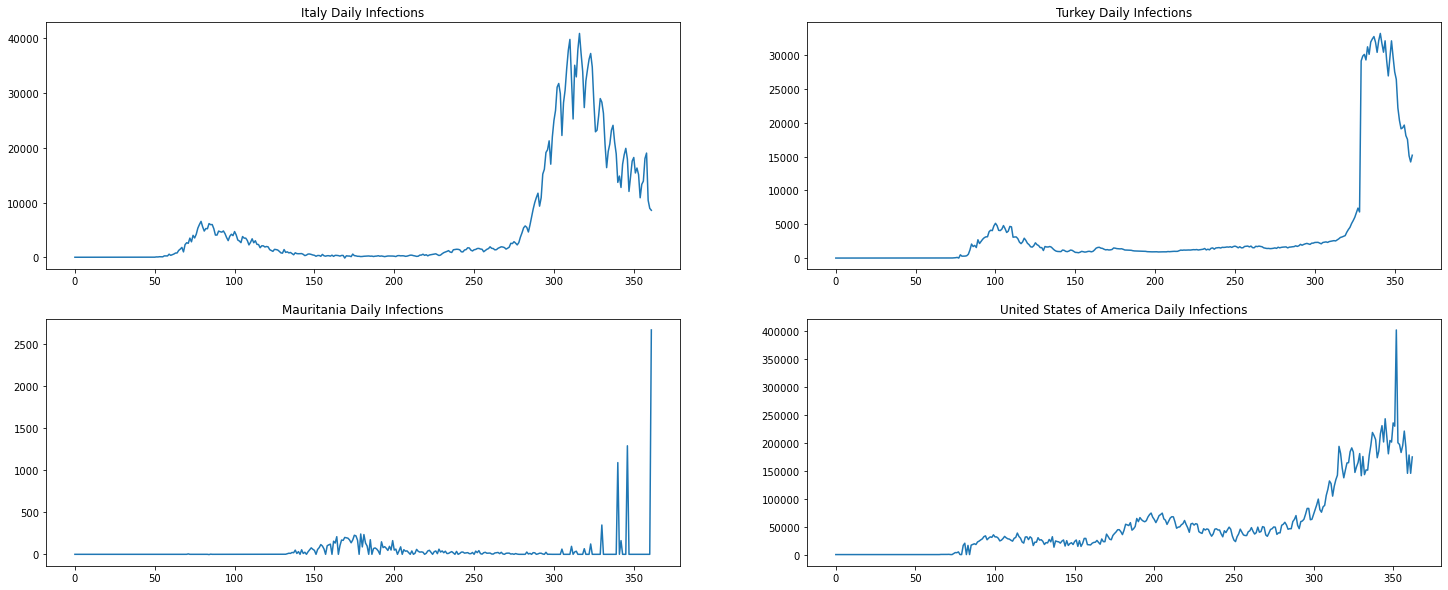

In [7]:
country_ls = ["Italy","Turkey","Mauritania","United States of America"]

fig, axes = plt.subplots(2,2,figsize=(25,10))
for i, ax in enumerate(axes.ravel()):
    country = country_ls[i]
    new_cases = covid_data[covid_data["Country"] == country]
    ax.set_title(country + " Daily Infections")
    ax.plot(new_cases["Date_reported"],new_cases["New_cases"])
    

### 1.4 Preprocess cultural dataset
We first take average per country, and then we convert numeric values into categorical values by breaking them into 3 bins (low,medium,high). 

In [8]:
# Obtain categorical columns
cate_col_name = ["V57","V60","V61","V62","V63","V64","V65","V80","V81","V144","V230"]
num_col_name = [x for x in cultural_data.columns if x not in cate_col_name]
num_col_name.remove("V2")

# Take average per country for numeric values and mode per country for categorical values
cate_col = cultural_data.groupby(["V2"])[cate_col_name].agg(pd.Series.mode)
num_col = cultural_data.groupby(["V2"])[num_col_name].mean()

# Convert numeric values into categorical by binning
for col in num_col.columns:
    maximum = num_col[col].max()
    minimum = num_col[col].min()
    dif = maximum - minimum
    
    bins = [minimum-1, minimum + 0.2*dif, minimum + 0.8*dif, maximum]
    labels = range(3)
    num_col[col] = pd.cut(num_col[col], bins=bins, labels=labels)

cleaned_df = pd.concat([cate_col, num_col],axis=1).reset_index()

We only select the representative countries for demonstration purposes

In [9]:
country_file = "../data_set/cultural_data/clean_data/country.csv"
country_name = pd.read_csv(country_file)

cleaned_df["V2"] = [country_name[country_name["index"]==x].iloc[0]["name"] for x in cleaned_df["V2"]]
cleaned_df

,V2,V60,V61,V62,V63,V64,V65,V80,V81,V144,...,V240,V241,V242,V243,V245,V246,V248,V249,V250,V253
0,Algeria,1.0,2.0,3.0,3.0,4.0,4.0,1.0,2.0,5,...,1,2,1,2,2,2,1,0,1,1
1,Argentina,1.0,3.0,3.0,3.0,1.0,4.0,1.0,1.0,4,...,1,1,1,2,2,2,1,1,1,2
2,Australia,1.0,3.0,1.0,3.0,1.0,4.0,1.0,1.0,4,...,1,0,2,2,0,2,2,1,2,1
3,Brazil,1.0,3.0,1.0,3.0,4.0,1.0,1.0,1.0,4,...,1,1,1,2,2,2,1,2,2,2
4,Chile,1.0,3.0,1.0,3.0,1.0,4.0,1.0,1.0,4,...,1,1,1,2,2,2,1,0,2,2
5,China,1.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,0,...,1,1,1,0,0,2,1,0,1,2
6,Colombia,1.0,3.0,1.0,4.0,1.0,4.0,1.0,1.0,4,...,1,1,1,2,2,2,1,0,1,2
7,Ecuador,1.0,3.0,1.0,3.0,1.0,4.0,1.0,1.0,4,...,1,1,1,2,2,2,1,0,1,2
8,Estonia,1.0,3.0,3.0,3.0,1.0,4.0,1.0,1.0,0,...,1,1,1,2,2,2,1,0,2,1
9,Georgia,1.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,4,...,1,1,1,2,2,2,2,0,1,1


### 1.5 Combine both dataset
We select the intersections of countries in both datasets and combine them for future analysis.

In [ ]:
# Check for non overlapping countries
country_dif = set(cleaned_df["V2"]) - set(country_df["country"])
print(country_dif)

# Delete Hong Kong in cultural data
cleaned_df = cleaned_df[cleaned_df["V2"] != "Hong Kong"]

# Change the country name in covid data
rep_dic = {"Republic of Korea":"South Korea", "Russian Federation":"Russia", "United States of America":"United States"}
country_df = country_df.replace(rep_dic)

cleaned_df["growth_rate"] = [country_df[country_df["country"] == x]["growth_rate"].iloc[0] for x in cleaned_df["V2"]]

cleaned_df.to_csv("../data_set/cultural_covid_data.csv",index=False)

We plot the correlation matrix by selecting attributes index manually along with the growth rate and see the correlation between cultual attributes and covid growth rate.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


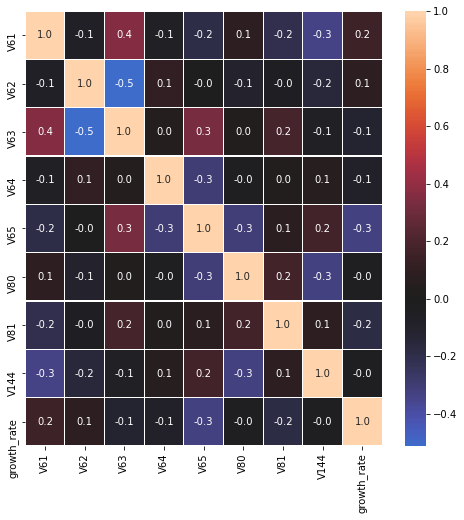

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Manually choose which attributes to show correlation by index
start_index = 2
end_index = 10

fig, ax = plt.subplots(figsize=(8,8)) 
cleaned_df.iloc[:,1:] = cleaned_df.iloc[:,1:].astype(float)

temp_df = pd.concat([cleaned_df.iloc[:,start_index:end_index],cleaned_df["growth_rate"]],axis=1)

corr = temp_df.corr()
sns.heatmap(corr, center=0, annot=True, linewidths=.1, fmt= '.1f', ax=ax)

,title,text,correlation coefficients
0,V65,A stable economy,-0.325993
1,V101,People get rich at the expense of others - enough wealth for everyone,-0.309967
2,V134,People receive state aid for unemployment.,0.330061
3,V150,Basic meaning of religion is to follow norms and ceremonies-to do good to other people,-0.354399
4,V201,Cheating on taxes if you have a chance,-0.337839
5,V233,Independence in performing tasks at work,-0.340627
6,V250,Do you live with your parents?,0.312258


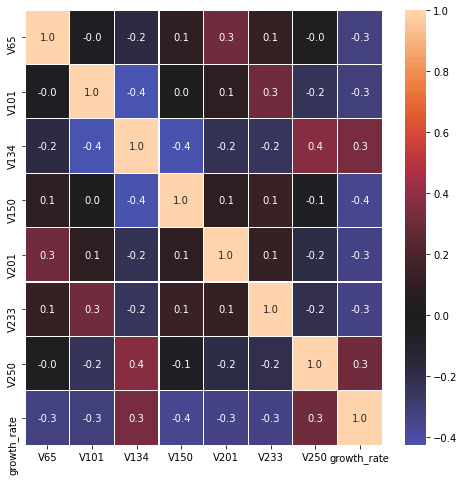

In [77]:
# Find all cultural attributes with absolute value of correlation >= 0.3
corr = cleaned_df.corr()
ls = list(corr[abs(corr["growth_rate"]) >= 0.3].index)

fig, ax = plt.subplots(figsize=(8,8))

temp_df = cleaned_df.loc[:,ls]

corr = temp_df.corr()
sns.heatmap(corr, center=0, annot=True, linewidths=.1, fmt= '.1f', ax=ax)

# Find corresponding questions with the important cultural attributes
WVS_questions = "../data_set/cultural_data/clean_data/WVS_topics_questions2.csv"
questions = pd.read_csv(WVS_questions, header=None)
questions.columns = ["title","min","max","type","norm_type","text"]

covid_questions = questions[questions["title"].isin(ls)][["title","text"]]
covid_corr = corr["growth_rate"].reset_index()
covid_corr.columns = ["title","growth_rate"]
covid_questions = pd.merge(covid_questions,covid_corr, on="title")
covid_questions.columns = ["title","text","correlation coefficients"]

pd.set_option('display.max_colwidth', None)

covid_questions